### Importation des bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Initialisation

#### Défintion des fonctions d'activation utilisées dans le réseau de neurones et de leurs dérivées :

In [2]:
def arctan_bornee(x):
    return np.arctan(x)*(2/np.pi)

def identity(x):
    return x

def th(x):
    return np.tanh(x)

def derivee_arctan_bornee(x):
    return (1/(1+x**2))*(2/np.pi)

def derivee_th(x):
    return 1 - (np.tanh(x))**2

### Notations :

* $m_q$ : le nombre de neurones de la couche $(q)$

* $W^{(q)}$ : matrice des poids de la couche $(q)$ qui est de taille $m_{q-1} \times m_{q}$

* $f^{(q)}_a$ : fonction d'activation de la couche $(q)$

* $Y^{(q)}$ : sortie de la couche $(q)$ après application de la fonction d'activation

* $Z^{(q)}$ : sortie de la couche $(q)$ avant application de la fonction d'activation, on obtient donc la relation: 

${} \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; Y^{(q)} = f^{(q)}_a\left(Z^{(q)}\right) = f^{(q)}_a\left( Y^{(q-1)}.W^{(q)} \right) $

(Si l'écriture ne s'affiche pas re-éxécutez la cellule)

# I- Création des classes Layer (couche) et NN (réseau de neurones):

### 1) Création de la classe Layer :

In [3]:
class Layer:
    def __init__(self, size, previous_size, activation_function):

        # Add verification of the types
        
        self.size = int(size)
        self.activation_function = activation_function
        self.previous_size = int(previous_size)

        self.weights = np.random.random([previous_size, size])

        self.offsets = []
        self.initialized_offsets = False

    def weighting(self, input):
        '''Sortie Z de la couche (avant application de la fonction d'activation).'''
        
        if self.initialized_offsets:
            return input @ self.weights + self.offsets

        else:
            return input @ self.weights

    def push_forward(self, input):
        '''Sortie Y de la couche (après application de la fonction d'activation).'''
        
        return self.activation_function(self.weighting(input))
        

### 2) Création de la classe NN :

##### Notations matricielles:

* $X$ : données d'entrée du réseau de neurones (batch du lot d'entraînement)

* $Y^{(3)}$ : sorties du réseau de neurones

* $N_{batch}$ : taille des batch du lot d'entraînement

* On est dans le cas d'une regression, on choisit l'écart quadratique moyen comme notre fonction d'erreur $\epsilon$ :

$ \; \; \;  \; \; \;  \; \; \;  \; \; \;  \; \; \; \epsilon = \dfrac{1}{N_{batch}} \sum_{i=1}^{N_{batch}} \left( {y_i}^{(3)} - sin(X)  \right)^2 =\dfrac{1}{N_{batch}} \left (sin(X)-Y^{(3)} \right)$ 

* $\dfrac{\partial \epsilon}{\partial w^{(q)}}$ : matrice des dérivées partielles de $\epsilon$ par rapport aux poids de la couche $(q)$ ( $q$-ième composante de $\overrightarrow{\nabla} \epsilon$ )

D'après les résultats du cours : 

$ \left \{  \begin{array}{r c l} \Delta^{(1)} & = & -2\left(sin(X) - Y \right)  \\ \Delta^{(2)} & = & \left[\Delta^{(3)} . {}^t(W^{(3)})  \right] {f_a}^\prime(Z^{(2)}) \\ \Delta^{(1)} & = & \left[\Delta^{(2)} . {}^t(W^{(2)})  \right] {f_a}^\prime(Z^{(1)})  \end{array} \right .  \; ; \; \left \{  \begin{array}{r c l}      \dfrac{\partial \epsilon}{\partial w^{(3)}} & = &  \dfrac{1}{N_{batch}}  \left[{}^t (Y^{(2)}) .\Delta^{(3)} \right] \\    \dfrac{\partial \epsilon}{\partial w^{(2)}} & = & \dfrac{1}{N_{batch}}  \left[{}^t (Y^{(1)}) .\Delta^{(2)} \right] \\ \dfrac{\partial \epsilon}{\partial w^{(1)}} & = & \dfrac{1}{N_{batch}}  \left[{}^t (X) .\Delta^{(1)} \right]   \end{array}    \right.  \; ; \;  \overrightarrow{\nabla} \epsilon = \left(\dfrac{\partial \epsilon}{\partial w^{(1)}};\dfrac{\partial \epsilon}{\partial w^{(2)}};\dfrac{\partial \epsilon}{\partial w^{(3)}}  \right) $



In [4]:
class NeuralNetwork:
    def __init__(self, layers_sizes, activation_functions, derivatives_activation_functions):

        self.layers_sizes = [1] + list(layers_sizes) + [1]
        self.activation_functions = activation_functions + [identity]
        self.derivatives_activation_functions = derivatives_activation_functions + [identity]
        self.layers = []
        self.loss = []

        
        self.data_size = 0

        
        self.delta = 0
    
        for i in range(len(layers_sizes)+1):
            self.layers.append(Layer(self.layers_sizes[i+1], self.layers_sizes[i], self.activation_functions[i]))
        self.number_layers = len(self.layers)

    def layer_output(self, layer_index, input):
        return self.layers[layer_index].push_forward(input)

    def predict(self, data, enable_offsets=False):

        self.data_size = data.size
        if enable_offsets:
            self.initialize_offsets(self.data_size)
        else:
            self.disable_offsets()
        input = np.reshape(data, (self.data_size, 1))
        self.outputs = []
        for j in range(self.number_layers):
            self.outputs.append(self.layer_output(j, input))
            input = self.outputs[j]
            #print(j)
            #print(input.shape)
        return self.outputs[-1]

    def initialize_offsets(self, data_size):
        for layer in self.layers:
            layer.offsets = np.random.random((data_size, layer.size))
            layer.initialized_offsets = True

    def disable_offsets(self):
        for layer in self.layers:
            layer.offsets = []
            layer.initialized_offsets = False

    def push_backward(self, data, enable_offset=False):

        self.predict(data, enable_offset)
        self.data_size = data.size
        Data = np.reshape(data, (self.data_size, 1))
        delta = []
        grad = []

        delta.append(- 2 * (np.sin(Data) - self.predict(data)))

        for i in range(1, self.number_layers):
            k = self.number_layers - i -1
            grad.append( (self.outputs[k].T @ delta[i-1]) / self.data_size )
            if i != self.number_layers-1:
                coeff = self.derivatives_activation_functions[k](self.layers[k].weighting(self.outputs[i-1]))
                delta.append( (delta[i-1] @ self.layers[k+1].weights.T) * coeff  )
        coeff = self.derivatives_activation_functions[0](self.layers[0].weighting(Data))
        delta.append( (delta[-1] @ self.layers[1].weights.T) * coeff  )
        grad.append( (Data.T @ delta[-1]) / self.data_size )

        nabla = np.array(grad, dtype='object')
        nabla = nabla[::-1]

        self.delta = delta
        
        return nabla

    def train(self, Data_train,nb_epochs,batch_size,learning_rate,plot=True):
            
        self.loss = np.zeros(nb_epochs) #Fonction erreur (écart), utilisée plus bas
        nb_batchs = int(len(Data_train) / batch_size)
        indices = np.arange(len(Data_train))
            
        for i in range(nb_epochs):  #Boucle sur les epochs
                
            np.random.shuffle(indices)  #On mélange les indices
            Data_melangee = Data_train[indices]  #On mélange les données à chaque époch
            
            
            for j in range(nb_batchs):  #Boucle sur les batchs
                    
                X_train = Data_melangee[batch_size*j:batch_size*(j+1)]
                #On parcourt l'ensemble du lot de données à chaque epoch
                                        
                self.predict(X_train, enable_offsets=False) #Push forward
                    
                nabla = self.push_backward(X_train) #Tableau des gradients pour chaque Layer

                for k in range(self.number_layers):
                    #Back propagation du gradient
                    self.layers[k].weights = self.layers[k].weights - learning_rate * nabla[k]                      
                    #self.layers[k].offsets = self.layers[k].offsets - learning_rate * self.delta[self.number_layers - k - 1]     
            
            Data_train = np.reshape(Data_train,(640,1))    
            
            #Calcul de la valeur de la fonction d'erreur à chaque epoch
            self.loss[i] = np.mean( (np.sin(Data_train) - self.predict(Data_train)  )**2  ) 



        if plot==True:
            tab_epochs = np.arange(1,nb_epochs+1)
            
            plt.figure(figsize=[15,5])
            #On trace la fonction erreur en fonction des epochs
            plt.subplot(1,3,1)
            plt.xlabel('epochs')
            plt.ylabel("Fonction d'erreur pour le lot d entrainement")
            plt.plot(tab_epochs, self.loss,label='loss function')
            plt.legend()

            plt.subplot(1,3,2)
            plt.xlabel('epochs')
            plt.plot(tab_epochs[:50], self.loss[:50],label='loss function')
            plt.title('Evolution de la fonction d erreur en fonction des epochs pour le lot d entrainement')
            plt.legend()

            plt.subplot(1,3,3)
            plt.xlabel('epochs')
            plt.plot(tab_epochs[50:], self.loss[50:],label='loss function')
            plt.legend()
            
            plt.figure()
            #On superpose les sorties du NN au graphe de sin(x)
            plt.scatter(Data_train,self.predict(Data_train),marker='.',label='prédictions du NN')
            abcisse = np.linspace(np.min(Data_train),np.max(Data_train),1000)
            plt.plot(abcisse,np.sin(abcisse),color='red',label=r'$sin(x)$')
            plt.legend()
            plt.title('Superposition des sorties du NN à la courbe de sin(x)')
            return self.loss    

    


Commentaires :

* On ne rajoute pas les biais, ce modèle plus rapidement sans biais lors de tests.


------------

# II- Entraînement du réseau de neurones, approximation de la fonction $\sin(x)$

On entraîne notre réseau de neurones sur les intervalles suivantes : $\left[ -\dfrac{\pi}{2}; \dfrac{\pi}{2} \right ]$, $\left[-\pi ; \pi  \right ]$, $\left[-2\pi ; 2\pi  \right ]$, $\left[-3\pi ; 3\pi  \right ]$ et $\left[-4\pi ; 4\pi  \right ]$

On utilisera les paramètres d'entraînement suivants :
* taille des batchs = 64
* nombre d'epochs = 5000
* learning rate = 0.01

On réseau de neurones est un multilayer-perceptron à $3$ couches ayant :

* $50-100-1$ neurones respectivement.
* $\dfrac{2}{\pi}\arctan(x) \; - \; \tanh(x) $ pour fonctions d'activation respectivement.

In [5]:
nb_neurones = [50, 100]
fonctions_activation = [arctan_bornee, th]
derivee_fonctions_activation = [derivee_arctan_bornee, derivee_th]

### 1) Entraînement sur $\left[-\dfrac{\pi}{2} ; \dfrac{\pi}{2}\right]$ :

In [6]:
Data_train_demi_periode = np.random.uniform(-np.pi/2,np.pi/2, 640)

In [7]:
NN_demi_periode = NeuralNetwork(nb_neurones, fonctions_activation, derivee_fonctions_activation)

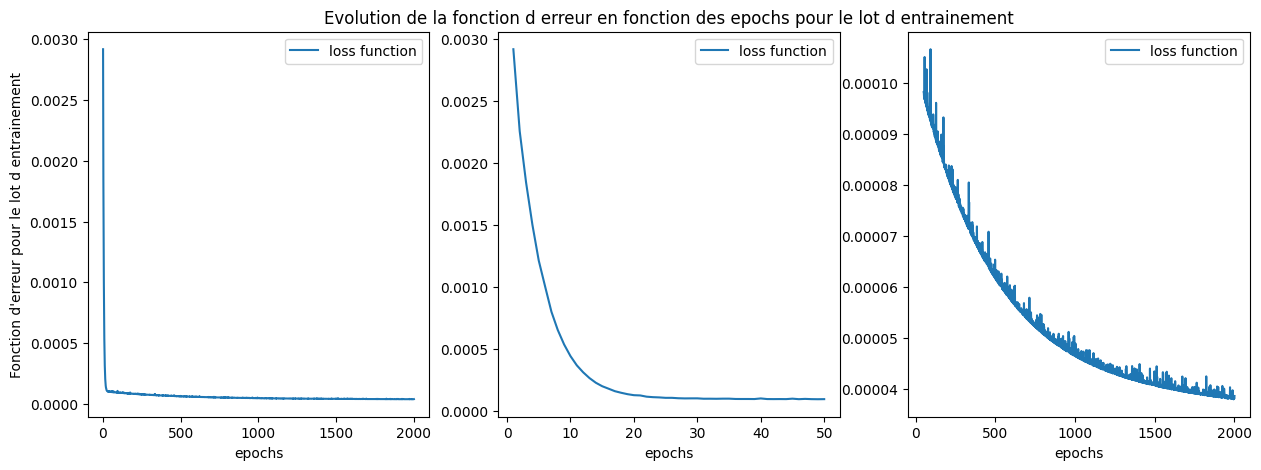

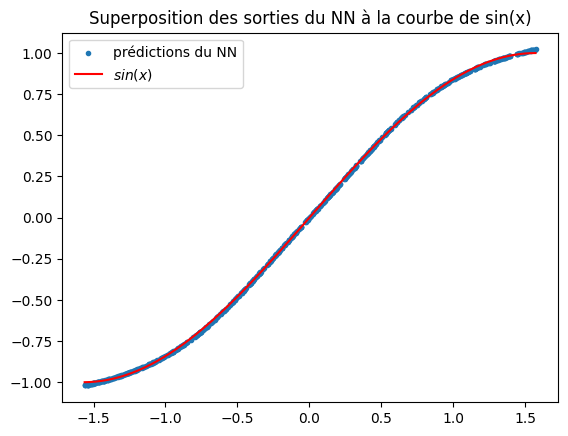

In [8]:
loss_demi_periode = NN_demi_periode.train(Data_train = Data_train_demi_periode, nb_epochs = 2000,
                batch_size=64, learning_rate = 0.01, plot = True)

* La fonction erreur commence à s'approcher de son minimum global aprèes environ 7000 epochs.

* L'ordre de grandeur de la fonction d'erreur est de $10^{-5}$

### 2) Entraînement sur $\left[-\pi ; \pi \right]$ :

In [9]:
Data_train_1_periode = np.random.uniform(-np.pi,np.pi, 640)  

In [10]:
NN_1_periode = NeuralNetwork(nb_neurones, fonctions_activation, derivee_fonctions_activation)

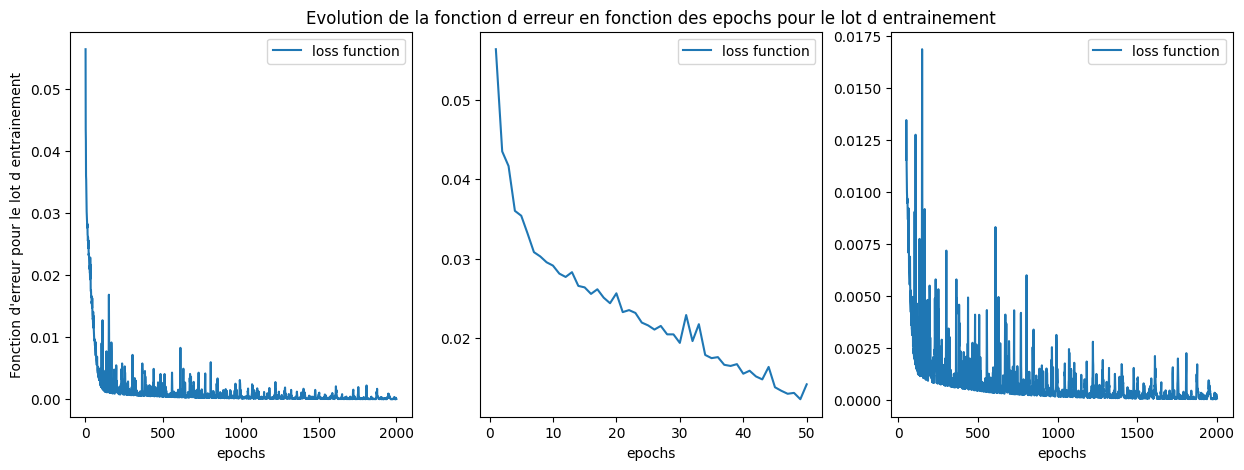

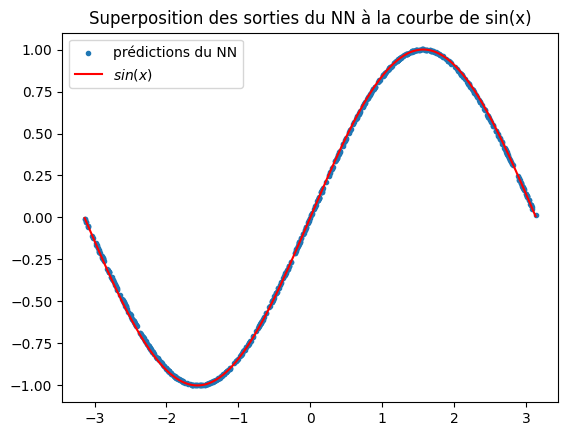

In [11]:
loss_1_periode = NN_demi_periode.train(Data_train = Data_train_1_periode, nb_epochs = 2000,
                batch_size=64, learning_rate = 0.01, plot = True)

* La décroissance est plus lente par rapport à la figure précédente

### 3) Entraînement sur $\left[-2\pi ; 2\pi \right]$ :

In [12]:
Data_train_2_periode = np.random.uniform(-2*np.pi,2*np.pi, 640)  

In [13]:
NN_2_periode = NeuralNetwork(nb_neurones, fonctions_activation, derivee_fonctions_activation)

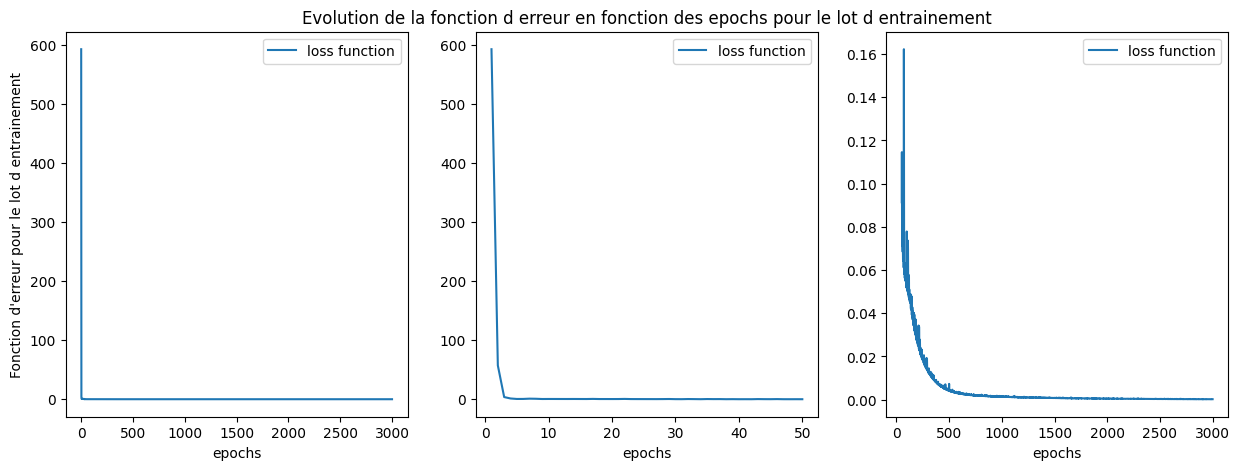

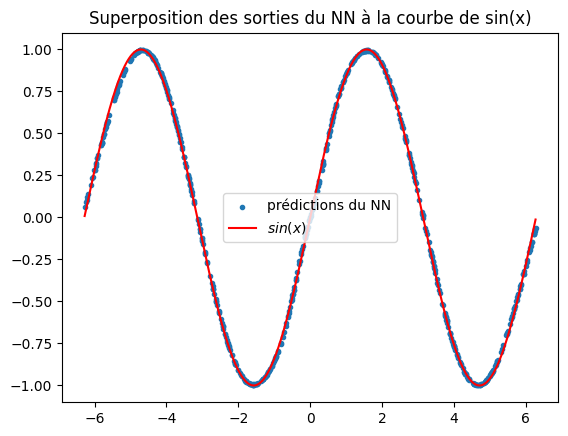

In [14]:
loss_2_periode = NN_2_periode.train(Data_train = Data_train_2_periode, nb_epochs = 3000,
                batch_size=64, learning_rate = 0.01, plot = True)

* La décroissance est de la fonction erreur est nette

* Néanmoins, la décroissance est plus lente par rapport à la figure précédente

* L'erreur est plus élevée que précédemment

### 4) Entraînement sur $\left[-3\pi ; 3\pi \right]$ :

In [51]:
Data_train_3_periode = np.random.uniform(-3*np.pi,3*np.pi, 640)

In [52]:
NN_3_periode = NeuralNetwork(nb_neurones, fonctions_activation, derivee_fonctions_activation)

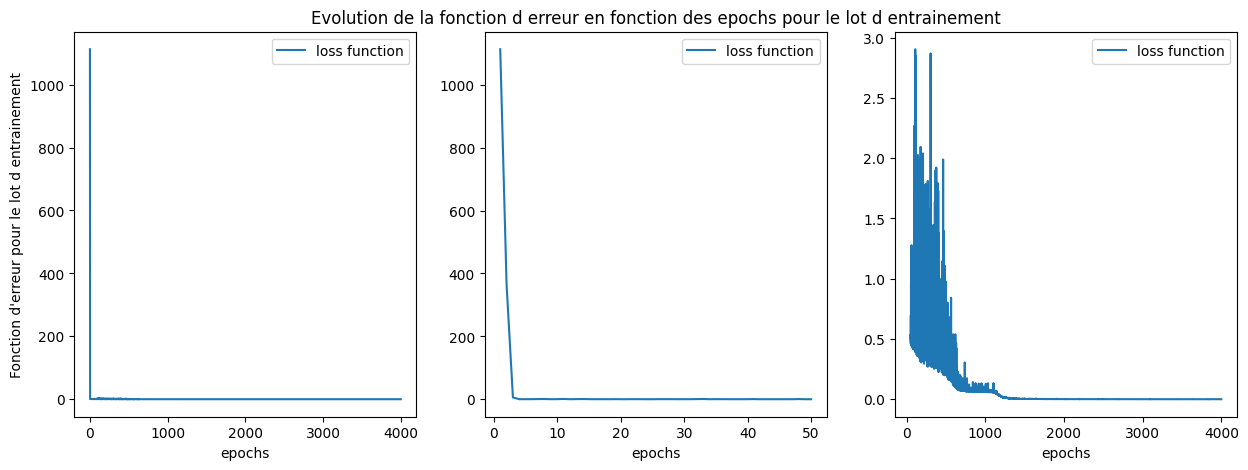

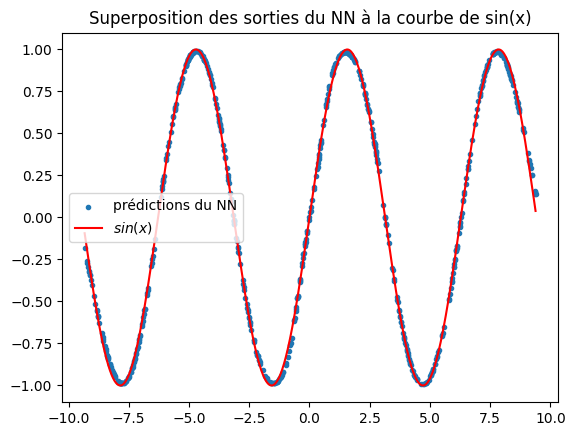

In [53]:
loss_3_periode = NN_3_periode.train(Data_train = Data_train_3_periode, nb_epochs = 4000,
                batch_size=64, learning_rate = 0.01, plot = True)

* On observe le même cas de figure que précédemment

* L'ordre de grandeur de la fonction d'erreru est plus grand

Commentaires :

* Plus l'intervalle parcouru par nos données est grand, moins les sorties du réseau de neurones sont précises 

* Plus l'intervalle parcouru par notre lot d'entraînement est grand, plus la minimisation de la fonction d'erreur est lente

* Plus l'intervalle parcouru par notre lot d'entraînement est grand, plus la fonction d'erreur prend des valeurs grandes

---------------

# III- Recherche d'une taille optimale des batchs du lot d'entrainement

On cherche à savoir (si elle existe) une taille de batchs optimale pour le couple (nombre d'epochs = 5000 , learning rate = 0.01) parmi les tailles de batchs suivantes : 16 - 32 - 64 - 128

Entraînons d'abord notre réseau de neurones sur l'intervalle $\left [-\dfrac{\pi}{2} ; \dfrac{\pi}{2} \right]$ pour des batchs de tailles respectives de 16, 32, 64 et 128.

In [37]:
NN16 = NeuralNetwork([50, 100], [arctan_bornee, th], [derivee_arctan_bornee, derivee_th, derivee_th])
NN32 = NeuralNetwork([50, 100], [arctan_bornee, th], [derivee_arctan_bornee, derivee_th, derivee_th])
NN64 = NeuralNetwork([50, 100], [arctan_bornee, th], [derivee_arctan_bornee, derivee_th, derivee_th])
NN128 = NeuralNetwork([50, 100], [arctan_bornee, th], [derivee_arctan_bornee, derivee_th, derivee_th])
Data_final_train = np.random.uniform(-np.pi/2, np.pi/2, 640)

### Entraînement du réseau de neurones pour différentes tailles de batch

In [38]:
NN16.train(Data_train = Data_final_train, nb_epochs = 2000,
                batch_size=16, learning_rate = 0.01, plot = False)

NN32.train(Data_train = Data_final_train, nb_epochs = 2000,
                batch_size=32, learning_rate = 0.01, plot = False)

NN64.train(Data_train = Data_final_train, nb_epochs = 2000,
                batch_size=64, learning_rate = 0.01, plot = False)

NN128.train(Data_train = Data_final_train, nb_epochs = 2000,
                batch_size=128, learning_rate = 0.01, plot = False)

### Visualisation des valeurs de la fonction d'erreur en chaque point pour les différentes tailles des batchs du lot d'entraînement 

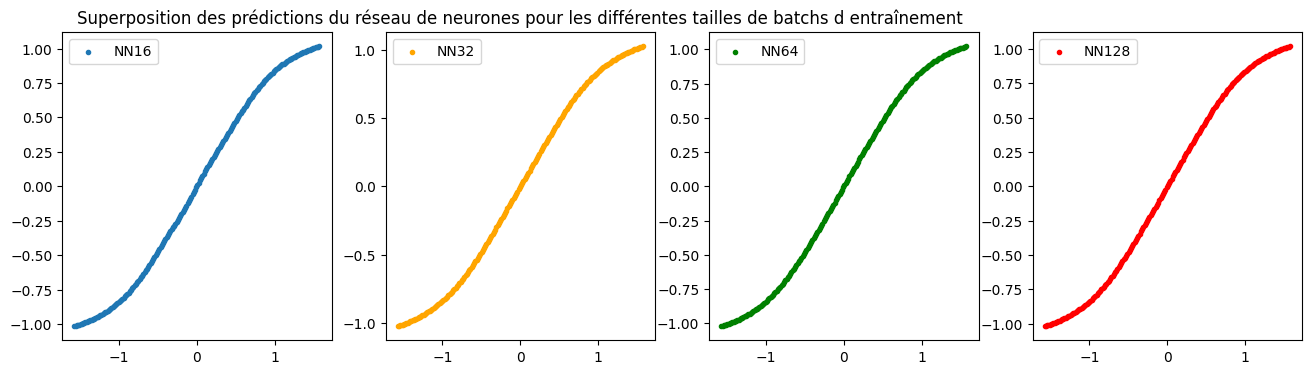

In [39]:
data_compar = np.linspace(-np.pi/2,np.pi/2,200) #abcisses des points
plt.figure(figsize=[16,4])
plt.subplot(1,4,1)
plt.scatter(data_compar, NN16.predict(data_compar), label='NN16',marker='.')
plt.legend()
plt.subplot(1,4,2)
plt.title('Superposition des prédictions du réseau de neurones pour les différentes tailles de batchs d entraînement')
plt.scatter(data_compar, NN32.predict(data_compar), label='NN32',marker='.',color='orange')
plt.legend()
plt.subplot(1,4,3)
plt.scatter(data_compar, NN64.predict(data_compar), label='NN64',marker='.',color='green')
plt.legend()
plt.subplot(1,4,4)
plt.scatter(data_compar, NN128.predict(data_compar), label='NN128',marker='.',color='red')
plt.legend()


Après entrainement de notre réseau pour des batchs de tailles respectives de 16, 32, 64 et 128,  cherchons laquelle de ces taille est optimale c-a-d aboutit à la plus faible valeur de la fonction d'erreur (erreur quadratique) pour le couple (nb_epochs=500 ; learning_rate = 0.01) 

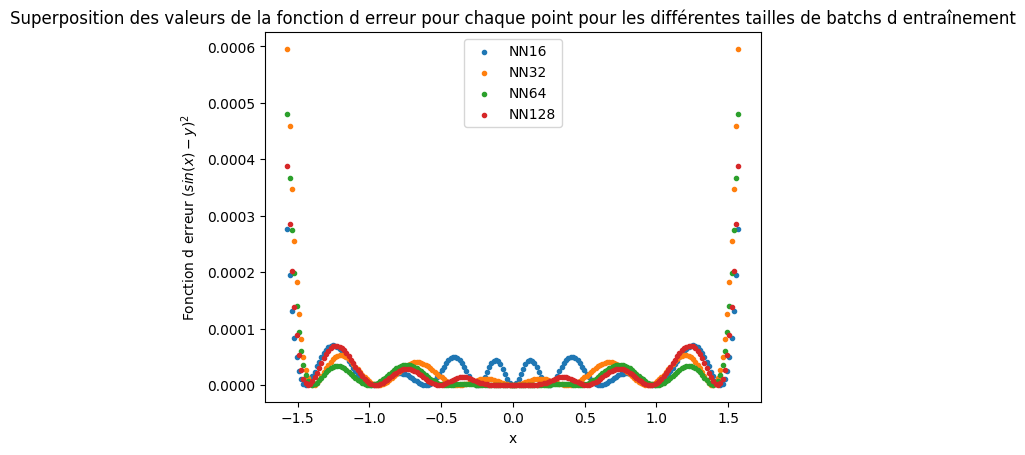

In [40]:
plt.figure()
data_compar = np.reshape(data_compar,(200,1))
plt.scatter(data_compar, (NN16.predict(data_compar)-np.sin(data_compar))**2,label='NN16' ,marker='.')
plt.scatter(data_compar, (NN32.predict(data_compar)-np.sin(data_compar))**2,label='NN32' ,marker='.')
plt.scatter(data_compar, (NN64.predict(data_compar)-np.sin(data_compar))**2,label='NN64' ,marker='.')
plt.scatter(data_compar, (NN128.predict(data_compar)-np.sin(data_compar))**2,label='NN128' ,marker='.')
plt.legend()
plt.title('Superposition des valeurs de la fonction d erreur pour chaque point pour les différentes tailles de batchs d entraînement')
plt.xlabel('x')
plt.ylabel(r'Fonction d erreur $\left( sin(x) - y \right)^2$')
plt.show()

### Visualisation de la valeur moyenne de la fonction d'erreur pour les différentes tailles des batchs du lot d'entraînement 

Text(0.5, 0, 'batch_size')

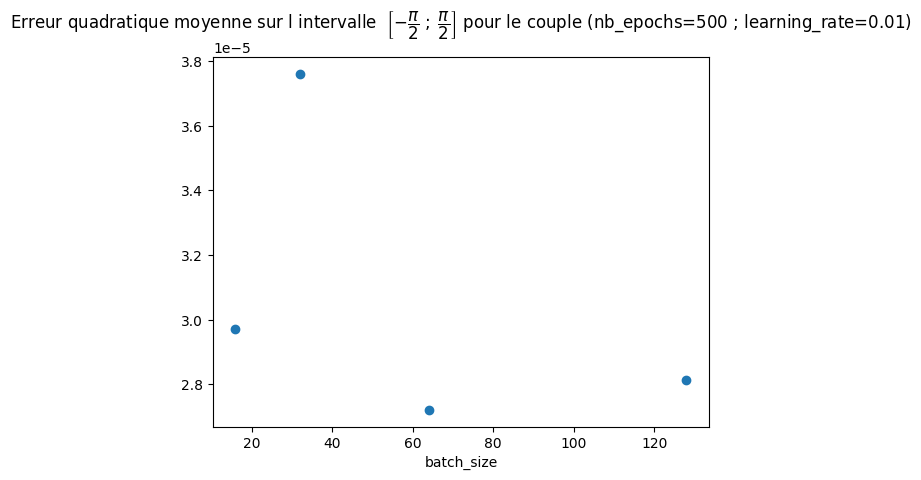

In [41]:
Loss_comparee = [ np.mean( (NN16.predict(data_compar)-np.sin(data_compar))**2) , np.mean( (NN32.predict(data_compar)-np.sin(data_compar))**2), np.mean( (NN64.predict(data_compar)-np.sin(data_compar))**2) ,np.mean( (NN128.predict(data_compar)-np.sin(data_compar))**2) ]
tab_tailles_batchs = [16,32,64,128]
plt.figure()
plt.title(r'Erreur quadratique moyenne sur l intervalle  $\left[-\dfrac{\pi}{2} \; ; \; \dfrac{\pi}{2} \right]$ pour le couple (nb_epochs=500 ; learning_rate=0.01)')
plt.scatter(tab_tailles_batchs,Loss_comparee)
plt.xlabel('batch_size')


Finalement, expérimentalement sur l'intervalle $I = \left[-\dfrac{\pi}{2} ;  \dfrac{\pi}{2} \right]$ pour le couple (nb_epochs=5000 ; learning_rate=0.01), la taille de batch minimisant l'erreur est  $64$